In [1]:
!pip install nltk spacy sacremoses sentencepiece contractions textblob Sastrawi transformers
!python3 -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 19.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.probability import FreqDist
from contractions import fix
from textblob import TextBlob
from sacremoses import MosesTokenizer
from transformers import BertTokenizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
factory = StopWordRemoverFactory()
stop_words = set(factory.get_stop_words())
moses_tokenizer = MosesTokenizer()
bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

print("Jumlah stopwords:", len(stop_words))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Jumlah stopwords: 123


In [5]:
# preprocessing
def remove_punctuation(text):
    """Menghapus tanda baca dari teks"""
    return re.sub(r'[^\w\s]', '', text)

def to_lowercase(text):
    """Mengubah teks menjadi huruf kecil"""
    return text.lower()

def remove_stopwords(tokens):
    """Menghapus stopwords dari daftar token"""
    return [w for w in tokens if w not in stop_words]

def apply_stemming(tokens):
    """Melakukan stemming pada daftar token"""
    # Gabungkan token jadi kalimat dulu, stemmer butuh string
    text = ' '.join(tokens)
    stemmed_text = stemmer.stem(text)
    # Tokenisasi lagi setelah stemming
    return stemmed_text.split()

In [6]:
# tokenization
def whitespace_tokenization(text):
    """Tokenisasi dengan whitespace"""
    return text.split()

def regex_tokenization(text):
    """Tokenisasi dengan regular expression"""
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

def penn_treebank_tokenization(text):
    """Tokenisasi dengan Penn Treebank"""
    tokenizer = TreebankWordTokenizer()
    return tokenizer.tokenize(text)

def moses_tokenization(text):
    """Tokenisasi dengan Moses"""
    return moses_tokenizer.tokenize(text)

def bert_subword_tokenization(text):
    """Tokenisasi dengan IndoBERT"""
    return bert_tokenizer.tokenize(text)

In [7]:
def freq_words(token_lists, terms=30):
    """
    Menampilkan kata paling sering dari daftar token

    Parameters:
    token_lists: list of token lists (misal df['tokens'])
    terms: jumlah kata paling sering yang ingin ditampilkan
    """
    all_words = [word for tokens in token_lists for word in tokens]

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    top_words = words_df.nlargest(columns='count', n=terms)

    # Plot
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=top_words, x='word', y='count', palette='rainbow')
    ax.set(ylabel='Count', xlabel='Word', title=f'Top {terms} Most Frequent Words')
    plt.xticks(rotation=45)
    plt.show()

In [8]:
def preprocessing_pipeline(text, tokenizer_type='regex', remove_stopwords_flag=True, apply_stemming_flag=True):
    """
    Pipeline lengkap untuk preprocessing teks

    Parameters:
    text: teks yang akan diproses
    tokenizer_type: jenis tokenizer yang digunakan ('whitespace', 'regex', 'treebank', 'moses', 'bert')
    remove_stopwords_flag: apakah menghapus stopwords
    apply_stemming_flag: apakah melakukan stemming

    Returns:
    Daftar token yang telah diproses
    """
    if pd.isna(text):
        return []

    # 1. Remove punctuation
    text = remove_punctuation(text)

    # 2. Lowercase
    text = to_lowercase(text)

    # 3. Tokenization
    if tokenizer_type == 'whitespace':
        tokens = whitespace_tokenization(text)
    elif tokenizer_type == 'regex':
        tokens = regex_tokenization(text)
    elif tokenizer_type == 'treebank':
        tokens = penn_treebank_tokenization(text)
    elif tokenizer_type == 'moses':
        tokens = moses_tokenization(text)
    elif tokenizer_type == 'bert':
        tokens = bert_subword_tokenization(text)
    else:
        tokens = regex_tokenization(text)  # default

    # 4. Remove stopwords (ops)
    if remove_stopwords_flag:
        tokens = remove_stopwords(tokens)

    # 5. Stemming (ops)
    if apply_stemming_flag:
        tokens = apply_stemming(tokens)

    return tokens

In [10]:
df = pd.read_csv("reviews_ferizy.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (4895, 8)


,reviewId,userName,content,score,thumbsUpCount,at,replyContent,repliedAt
0,8cf57e22-4087-4138-9458-1587f1995648,Pengguna Google,kenapa sekarang jadi susah banget pesan di fer...,1.0,0.0,2025-08-31 02:23:58,NaN,NaN
1,263652c4-1261-4faf-8fb0-58cd6ad84ef6,Pengguna Google,"ribet, ganti emoney aja praktis malah ga ada calo",1.0,0.0,2025-08-30 10:08:31,NaN,NaN
2,66809258-c506-4fe0-8455-3017d9bf5e0d,Pengguna Google,ok bgt,5.0,0.0,2025-08-30 03:05:22,NaN,NaN
3,88c8b351-b9ac-4fb6-85d1-3cb678428d0b,Pengguna Google,sangat buruk. pesanan hari ini tidak bisa dila...,1.0,0.0,2025-08-29 10:04:06,NaN,NaN
4,220b5b58-014f-4821-baf4-fee73df3adf4,Pengguna Google,jauh,1.0,0.0,2025-08-27 05:07:37,NaN,NaN


In [11]:
sample_text = df['content'].dropna().iloc[0] if not df['content'].dropna().empty else ""
print("Original Review:", sample_text)


Original Review: kenapa sekarang jadi susah banget pesan di ferizy...lemot parah dan muter2 terus kalo pesen, seperti nya ada sesuatu yg janggal


In [14]:
processed_tokens = preprocessing_pipeline(sample_text, tokenizer_type='regex',
                                         remove_stopwords_flag=True, apply_stemming_flag=False)
print("\nProcessed Tokens:", processed_tokens)



Processed Tokens: ['sekarang', 'jadi', 'susah', 'banget', 'pesan', 'ferizylemot', 'parah', 'muter2', 'terus', 'kalo', 'pesen', 'nya', 'yg', 'janggal']


In [15]:
print("\nMemproses seluruh dataset...")
df['processed_tokens'] = df['content'].apply(
    lambda x: preprocessing_pipeline(x, tokenizer_type='regex',
                                    remove_stopwords_flag=True, apply_stemming_flag=False)
)



Memproses seluruh dataset...


In [16]:
# Menampilkan hasil
df[['content', 'processed_tokens']].head()

,content,processed_tokens
0,kenapa sekarang jadi susah banget pesan di fer...,"[sekarang, jadi, susah, banget, pesan, ferizyl..."
1,"ribet, ganti emoney aja praktis malah ga ada calo","[ribet, ganti, emoney, aja, praktis, malah, ga..."
2,ok bgt,[bgt]
3,sangat buruk. pesanan hari ini tidak bisa dila...,"[sangat, buruk, pesanan, hari, dilakukan, kolo..."
4,jauh,[jauh]


/tmp/ipython-input-3811929463.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_words, x='word', y='count', palette='rainbow')


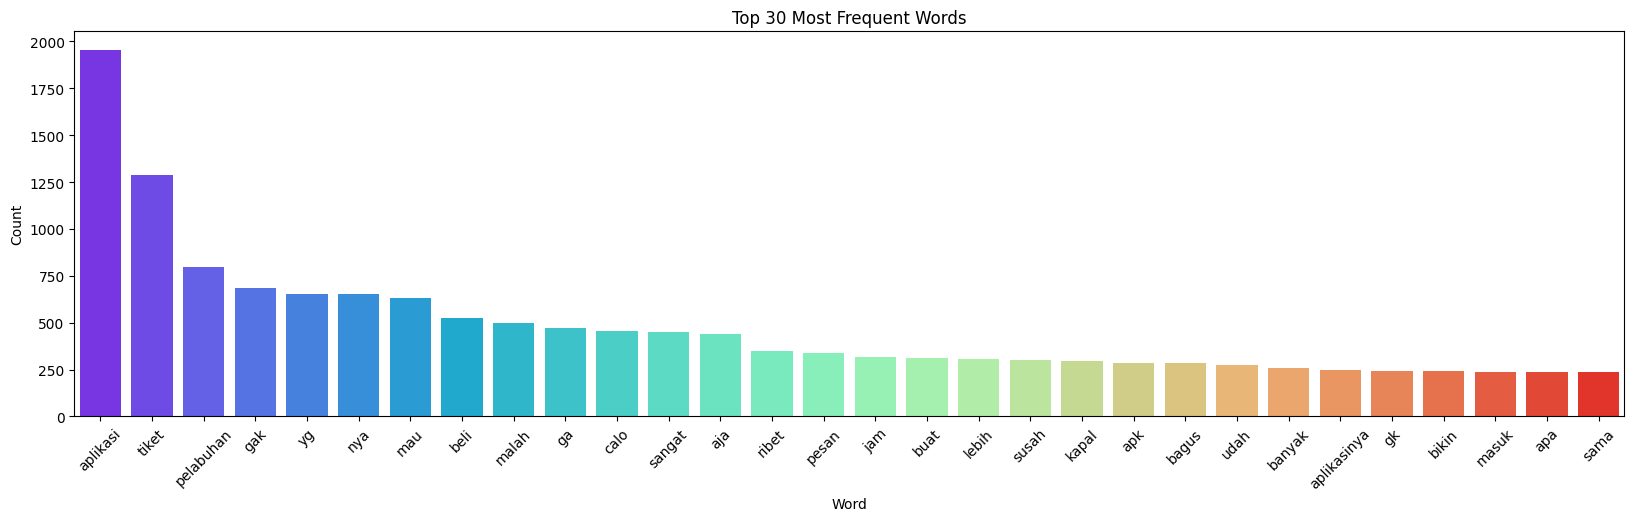

In [17]:
freq_words(df['processed_tokens'].dropna(), terms=30)

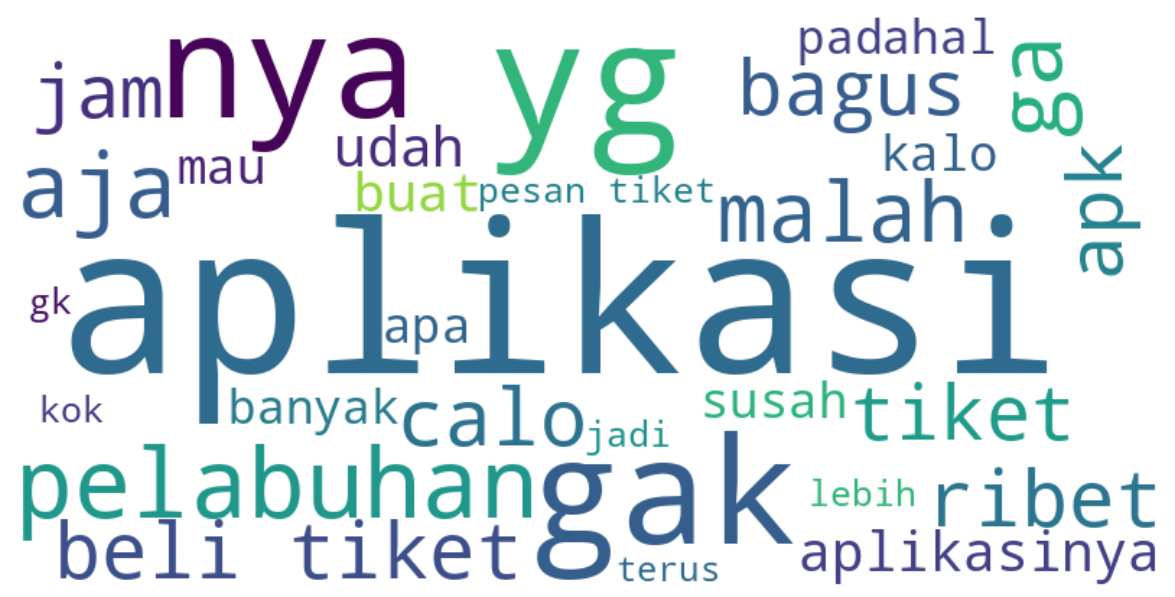

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = ' '.join([' '.join(tokens) for tokens in df['processed_tokens'].dropna()])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=30).generate(all_words)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [18]:
# Simpan hasil ke CSV
df[['content', 'processed_tokens']].to_csv('processed_data.csv', index=False)

                                             content  \
0  kenapa sekarang jadi susah banget pesan di fer...   
1  ribet, ganti emoney aja praktis malah ga ada calo   
2                                             ok bgt   
3  sangat buruk. pesanan hari ini tidak bisa dila...   
4                                               jauh   

                              processed_tokens_clean  
0  [sekarang, jadi, susah, banget, pesan, ferizyl...  
1   [ribet, ganti, emoney, praktis, malah, ga, calo]  
2                                              [bgt]  
3  [sangat, buruk, pesanan, hari, dilakukan, kolo...  
4                                             [jauh]  


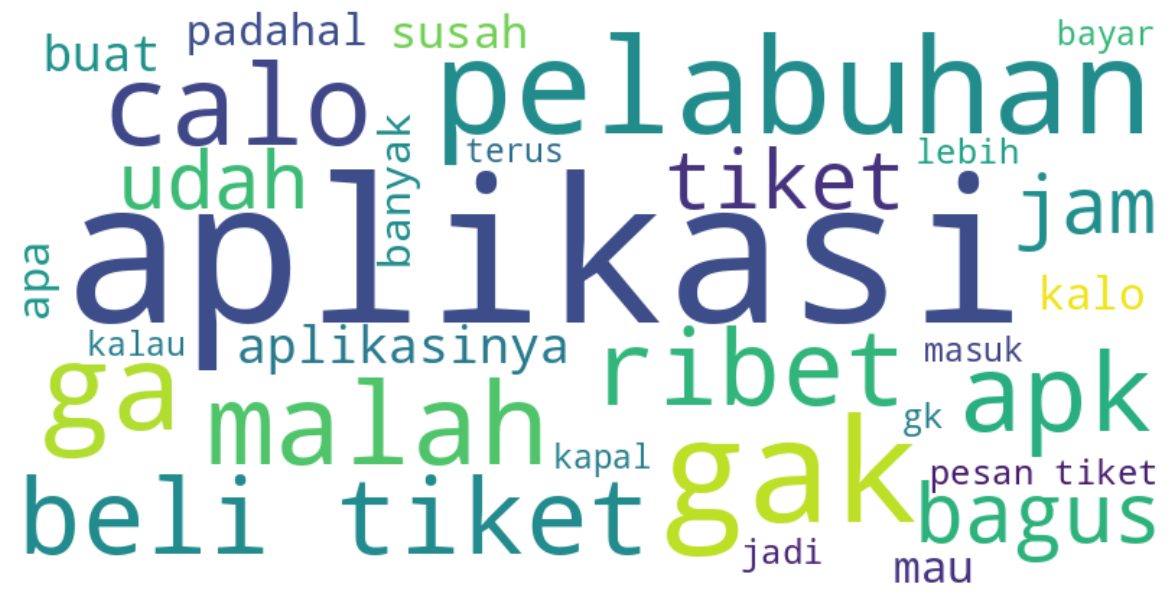

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

custom_stopwords = ['yg', 'aja', 'kok', 'nya']

df['processed_tokens_clean'] = df['processed_tokens'].apply(
    lambda tokens: [w for w in tokens if w not in custom_stopwords] if isinstance(tokens, list) else []
)

print(df[['content', 'processed_tokens_clean']].head())

all_words = ' '.join([' '.join(tokens) for tokens in df['processed_tokens_clean'].dropna()])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=30).generate(all_words)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [21]:
df[['content', 'processed_tokens_clean']].to_csv('processed_tokens_clean.csv', index=False)
